In [1]:
import os
import sys
import random
import warnings

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
dir_base = '/home/kebei/01_tgs_salt_id/01_data/'
path_train = os.path.join(dir_base, 'train')
path_test = os.path.join(dir_base, 'test')

In [3]:
train_ids = next(os.walk(os.path.join(path_train, "images")))[2]
test_ids = next(os.walk(os.path.join(path_test, "images")))[2]

In [4]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in enumerate(train_ids[0]):
    path = path_train
    img = load_img(path + '/images/' + id_)
    #print(type(img))
    #img.shape
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
print('Done!')
X_train.shape
Y_train.shape

Getting and resizing train images and masks ... 


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Done!


(4000, 128, 128, 1)

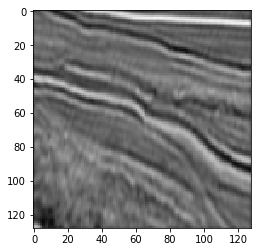

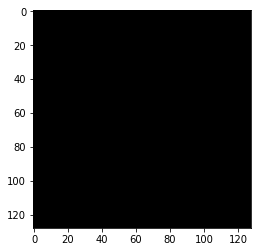

In [5]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [6]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [7]:
#device_name=["/gpu:0", "/gpu:1"]
device_name="/gpu:1"

In [8]:
# Build U-Net model
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [9]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=10, 
                    callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/10
3600/3600 [==============================] - 23s 6ms/step - loss: 0.5558 - mean_iou: 0.3703 - val_loss: 0.4721 - val_mean_iou: 0.3745

Epoch 00001: val_loss improved from inf to 0.47211, saving model to model-tgs-salt-1.h5
Epoch 2/10
3600/3600 [==============================] - 19s 5ms/step - loss: 0.4063 - mean_iou: 0.3850 - val_loss: 0.3580 - val_mean_iou: 0.4177

Epoch 00002: val_loss improved from 0.47211 to 0.35802, saving model to model-tgs-salt-1.h5
Epoch 3/10
3600/3600 [==============================] - 19s 5ms/step - loss: 0.3443 - mean_iou: 0.4450 - val_loss: 0.3547 - val_mean_iou: 0.4716

Epoch 00003: val_loss improved from 0.35802 to 0.35469, saving model to model-tgs-salt-1.h5
Epoch 4/10
3600/3600 [==============================] - 19s 5ms/step - loss: 0.3103 - mean_iou: 0.4949 - val_loss: 0.3056 - val_mean_iou: 0.5143

Epoch 00004: val_loss improved from 0.35469 to 0.30564, saving model to model-tgs-salt-1.h5
Epoch